In [1]:
import torch
torch.cuda.is_available()

False

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
pd.options.mode.chained_assignment = None
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score,roc_auc_score


In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam, SGD, Adagrad, AdamW, Adadelta 
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import pickle

In [5]:
#data frame with the filtered topic labels and features that characterize each data entry:

file = open("tfidf_topics.pkl",'rb')
df = pickle.load(file)
file.close()


Text(0, 0.5, 'Number of topics')

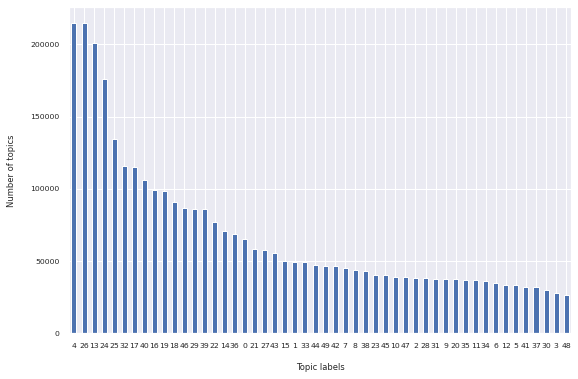

In [6]:
sns.set(font_scale=0.7)
df['text_tokens'].value_counts().plot(kind='bar', figsize=(9, 6), rot=0)
plt.xlabel("Topic labels", labelpad=14)
plt.ylabel("Number of topics", labelpad=14)
#plt.title("Histogram showing frequency of topics in the dataset", y=1.02);

In [7]:
#Tweet count for all the users considered
df['engaging_user_id'].value_counts()

72C2BE10D3673447A6D596E12C0523DA    502
3396F36ADFF2A01A34C0CB3486CABFEE    388
5049F4AC51D668D064214377EB38A8D3    320
3FC1A3B3B9C8D1BD6673C3B5B65A6E91    308
F1D8FA7C91B5EE653330E80D48C77AD1    297
                                   ... 
317B27842654F3E7B44506FB88C39C04     21
524EA0D7BC7EB37C1F7E70F1A35CD4F3     21
113E77E5C5FCFFAC72641FDE568BBDC2     21
1BE7F7D78962683BD21CD25545EBF2A7     21
3C09028A11CB817F4954432691C2E232     21
Name: engaging_user_id, Length: 107017, dtype: int64

In [8]:
#Convert date to yyyy-mm-dd hh:mm:ss format
import datetime
df['tweet_timestamp'] = df["tweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x)) 

In [9]:
t1 = df[(df["tweet_timestamp"] >= '2020-02-05 18:00:00') & (df["tweet_timestamp"] < '2020-02-06 06:00:00')]
t2 = df[(df["tweet_timestamp"] >= '2020-02-06 06:00:00') & (df["tweet_timestamp"] < '2020-02-06 18:00:00')]
t3 = df[(df["tweet_timestamp"] >= '2020-02-06 18:00:00') & (df["tweet_timestamp"] < '2020-02-07 06:00:00')]
t4 = df[(df["tweet_timestamp"] >= '2020-02-07 06:00:00') & (df["tweet_timestamp"] < '2020-02-07 18:00:00')]
t5 = df[(df["tweet_timestamp"] >= '2020-02-07 18:00:00') & (df["tweet_timestamp"] < '2020-02-08 06:00:00')]
t6 = df[(df["tweet_timestamp"] >= '2020-02-08 06:00:00') & (df["tweet_timestamp"] < '2020-02-08 18:00:00')]
t7 = df[(df["tweet_timestamp"] >= '2020-02-08 18:00:00') & (df["tweet_timestamp"] < '2020-02-09 06:00:00')]
t8 = df[(df["tweet_timestamp"] >= '2020-02-09 06:00:00') & (df["tweet_timestamp"] < '2020-02-09 18:00:00')]
t9 = df[(df["tweet_timestamp"] >= '2020-02-09 18:00:00') & (df["tweet_timestamp"] < '2020-02-10 06:00:00')]
t10 = df[(df["tweet_timestamp"] >= '2020-02-10 06:00:00') & (df["tweet_timestamp"] < '2020-02-10 18:00:00')]
t11 = df[(df["tweet_timestamp"] >= '2020-02-10 18:00:00') & (df["tweet_timestamp"] < '2020-02-11 06:00:00')]
t12 = df[(df["tweet_timestamp"] >= '2020-02-11 06:00:00') & (df["tweet_timestamp"] < '2020-02-11 18:00:00')]
t13 = df[(df["tweet_timestamp"] >= '2020-02-11 18:00:00') & (df["tweet_timestamp"] < '2020-02-12 06:00:00')]
t14 = df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')]

# Each time period is 12 hrs
# Engagement frequency of user is from time periods t1 to t12 during training
# Recent history of user is considered from time periods t9 to t12 training 
# Current time period is considered as t13
# Testing will be carried out on time period t14


In [10]:
#Engagement frequency for testing time
eng_frequency = df[df["tweet_timestamp"] < '2020-02-12 6:00:00']
eng_frequency['retweet'] = np.where(pd.notnull(eng_frequency['retweet_timestamp']), 1, 0)
columns = ['tweet_timestamp', 'tweet_id', 'reply_timestamp', "retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
eng_frequency.drop(columns, axis=1,inplace=True)
engagement_history = eng_frequency.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
input_engagement_history = engagement_history.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
input_engagement_history.fillna(0,inplace = True)
history_frequency = pd.DataFrame(input_engagement_history.to_records())

In [11]:
#Engagement frequency for training time
eng_frequency_train = df[df["tweet_timestamp"] < '2020-02-11 18:00:00']
eng_frequency_train['retweet'] = np.where(pd.notnull(eng_frequency_train['retweet_timestamp']), 1, 0)
columns = ['tweet_timestamp', 'tweet_id', 'reply_timestamp', "retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
eng_frequency_train.drop(columns, axis=1,inplace=True)
engagement_history_train = eng_frequency_train.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
input_engagement_history_train = engagement_history_train.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
input_engagement_history_train.fillna(0,inplace = True)
history_frequency_train = pd.DataFrame(input_engagement_history_train.to_records())

In [12]:


columns = ['reply_timestamp','tweet_timestamp', 'tweet_id',"retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]


In [13]:
def final_history(z):
    xt = z
    columns = ['reply_timestamp','tweet_timestamp', 'tweet_id',"retweet_timestamp","retweet_with_comment_timestamp","like_timestamp"]
    xt['retweet'] = np.where(pd.notnull(xt['retweet_timestamp']), 1, 0)
    xt.drop(columns, axis=1)
    x_t = xt.groupby(['engaging_user_id', 'text_tokens'])[['retweet']].agg('sum')
    xt_history = x_t.pivot_table(index='engaging_user_id', columns='text_tokens', values='retweet')
    xt_history.fillna(0,inplace = True)
    history_xt = pd.DataFrame(xt_history.to_records())
    for col in history_xt.columns:
      if col != 'engaging_user_id':
        history_xt.loc[history_xt[col] > 1, col] = 1

    left_out_rows_xt = history_frequency[~history_frequency['engaging_user_id'].isin(history_xt['engaging_user_id'])]
    for col in left_out_rows_xt.columns:
        if col != 'engaging_user_id':
            left_out_rows_xt[col].values[:] = 0
    final_history_xt = history_xt.append(left_out_rows_xt)
    final_history_xt = final_history_xt.sort_values('engaging_user_id')
    final_history_xt.reset_index(drop=True)
    return final_history_xt

In [14]:
#dataframes with engagement histories  
from functools import reduce
recent_history = reduce(lambda x,y: pd.merge(x,y, on='engaging_user_id', how='outer'), [final_history(t9), final_history(t10), final_history(t11), final_history(t12)])
recent_history_test = reduce(lambda x,y: pd.merge(x,y, on='engaging_user_id', how='outer'), [final_history(t10), final_history(t11), final_history(t12), final_history(t13)])

In [15]:
history_frequency = history_frequency.sort_values('engaging_user_id')
history_frequency_train = history_frequency_train.sort_values('engaging_user_id')

In [16]:
def tweet_recommend(time):
    #time = df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')]
    left = time[time['retweet_timestamp'] >= 0]
    time['retweet_timestamp'].fillna(0,inplace=True)

    left['retweet_timestamp'] = left["retweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))
    time = pd.concat([time,left]).drop_duplicates(keep=False)
    time['retweet_timestamp'] = time['tweet_timestamp']
    final = pd.concat([time,left])

    final = final.sort_values(['engaging_user_id', 'retweet_timestamp'], ascending=[True, False])
    final = final.reset_index(drop=True)

    columns = ['tweet_id',"reply_timestamp","retweet_with_comment_timestamp","like_timestamp"]
    final.drop(columns, axis=1,inplace=True)
    
    final = active_recommend(final)
    column = ['tweet_timestamp','retweet_timestamp']
    final.drop(column, axis=1,inplace=True)
    print (final['recommend'].value_counts())
    final_1 = final.groupby(['engaging_user_id', 'text_tokens'])[['recommend']].agg('sum')
    final_2 = final_1.pivot_table(index='engaging_user_id', columns='text_tokens', values='recommend')
    final_2.fillna(0,inplace = True)
    final_3 = pd.DataFrame(final_2.to_records())

    for col in final_3.columns:
      if col != 'engaging_user_id':
        final_3.loc[final_3[col] > 1, col] = 1


    left_out_rows_f = history_frequency[~history_frequency['engaging_user_id'].isin(final_3['engaging_user_id'])]
    for col in left_out_rows_f.columns:
        if col != 'engaging_user_id':
            left_out_rows_f[col].values[:] = 0
    final_4 = final_3.append(left_out_rows_f)
    recommend_test = final_4.sort_values('engaging_user_id')
    recommend_test.reset_index(drop=True, inplace=True)
    return(recommend_test)

    
    

In [17]:
#topic recommendations generation for training and testing.

# time = df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')]
# left = time[time['retweet_timestamp'] >= 0]
# time['retweet_timestamp'].fillna(0,inplace=True)

# left['retweet_timestamp'] = left["retweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))
# time = pd.concat([time,left]).drop_duplicates(keep=False)
# time['retweet_timestamp'] = time['tweet_timestamp']
# final = pd.concat([time,left])

# final = final.sort_values(['engaging_user_id', 'retweet_timestamp'], ascending=[True, False])
# final = final.reset_index(drop=True)

# columns = ['tweet_id',"reply_timestamp","retweet_with_comment_timestamp","like_timestamp"]
# final.drop(columns, axis=1,inplace=True)


# time_1 = df[(df["tweet_timestamp"] >= '2020-02-11 18:00:00') & (df["tweet_timestamp"] < '2020-02-12 06:00:00')]
# left_1 = time_1[time_1['retweet_timestamp'] >= 0]
# time_1['retweet_timestamp'].fillna(0,inplace=True)

# left_1['retweet_timestamp'] = left_1["retweet_timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x))
# time_1 = pd.concat([time_1,left_1]).drop_duplicates(keep=False)
# time_1['retweet_timestamp'] = time_1['tweet_timestamp']
# initial = pd.concat([time_1,left_1])

# initial = initial.sort_values(['engaging_user_id', 'retweet_timestamp'], ascending=[True, False])
# initial = initial.reset_index(drop=True)

# columns = ['tweet_id',"reply_timestamp","retweet_with_comment_timestamp","like_timestamp"]
# initial.drop(columns, axis=1,inplace=True)

In [18]:
# We consider the positive examples for topic recommendations from all the tweets posted during the active states and vice versa. 
# An active state is defined as a period between when a tweet is published and engaged


#Function action_recommend for determining the active states
def active_recommend(x):
    g = 3
    for index, row in x.iterrows():
      if g != 10 :
        a = row['engaging_user_id']
        b = row['tweet_timestamp']
        c = row['retweet_timestamp']
        p = 0
        if b != c :
          g = 10
      if (row['tweet_timestamp'] != row['retweet_timestamp']):
          p = 1
          d = row['engaging_user_id']
          e = row['tweet_timestamp']
          f = row['retweet_timestamp']
      elif row['tweet_timestamp'] == row['retweet_timestamp']:
          if row['engaging_user_id'] == a:
            p = 0
          elif row['engaging_user_id'] == d:
            if (row['tweet_timestamp'] >= e) & (row['tweet_timestamp'] <= f):
              p = 1
            else:
              p = 0
      x.loc[index,'recommend'] = p
    return x
#final = active_recommend(final)    # Test Recommendations 
#inital = active_recommend(initial) # Training Recommendations

In [19]:
# column = ['tweet_timestamp','retweet_timestamp']
# final.drop(column, axis=1,inplace=True)
# initial.drop(column, axis=1,inplace=True)

In [20]:

# final_1 = final.groupby(['engaging_user_id', 'text_tokens'])[['recommend']].agg('sum')
# final_2 = final_1.pivot_table(index='engaging_user_id', columns='text_tokens', values='recommend')
# final_2.fillna(0,inplace = True)
# final_3 = pd.DataFrame(final_2.to_records())

# for col in final_3.columns:
#   if col != 'engaging_user_id':
#     final_3.loc[final_3[col] > 1, col] = 1
    
    
# left_out_rows_f = history_frequency[~history_frequency['engaging_user_id'].isin(final_3['engaging_user_id'])]
# for col in left_out_rows_f.columns:
#     if col != 'engaging_user_id':
#         left_out_rows_f[col].values[:] = 0
# final_4 = final_3.append(left_out_rows_f)
# recommend_test = final_4.sort_values('engaging_user_id')
# recommend_test.reset_index(drop=True, inplace=True)  #Dataframe with topic recommendation during testing

In [21]:
# initial_1 = initial.groupby(['engaging_user_id', 'text_tokens'])[['recommend']].agg('sum')
# initial_2 = initial_1.pivot_table(index='engaging_user_id', columns='text_tokens', values='recommend')
# initial_2.fillna(0,inplace = True)
# initial_3 = pd.DataFrame(final_2.to_records())

# for col in initial_3.columns:
#   if col != 'engaging_user_id':
#     initial_3.loc[final_3[col] > 1, col] = 1
    
# left_out_rows_g = history_frequency[~history_frequency['engaging_user_id'].isin(final_3['engaging_user_id'])]
# for col in left_out_rows_g.columns:
#     if col != 'engaging_user_id':
#         left_out_rows_f[col].values[:] = 0
# initial_4 = initial_3.append(left_out_rows_f)
# recommend = initial_4.sort_values('engaging_user_id')
# recommend.reset_index(drop=True, inplace=True)      #Dataframe with topic recommendation during training
    

In [22]:
#recommend_test = tweet_recommend(df[(df["tweet_timestamp"] >= '2020-02-12 06:00:00') & (df["tweet_timestamp"] < '2020-02-12 18:00:00')])
#recommend = tweet_recommend(df[(df["tweet_timestamp"] >= '2020-02-11 18:00:00') & (df["tweet_timestamp"] < '2020-02-12 06:00:00')])
recommend_test = tweet_recommend(t14)
recommend = tweet_recommend(t13)

1.0    287758
0.0    105948
Name: recommend, dtype: int64
1.0    221141
0.0     71676
Name: recommend, dtype: int64


In [99]:
X_recommend_t[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
X_recent_2 = recent_history.drop('engaging_user_id', axis=1).values
X_recent_1 = X_recent_2.reshape(-1,50,4)

X_recent_2_test = recent_history_test.drop('engaging_user_id', axis=1).values
X_recent_1_test = X_recent_2_test.reshape(-1,50,4)



X_freq_1 = history_frequency.drop('engaging_user_id', axis=1).values
X_freq_1_train = history_frequency_train.drop('engaging_user_id', axis=1).values


X_recommend_1 = recommend.drop('engaging_user_id', axis=1).values
X_recommend_t = recommend_test.drop('engaging_user_id', axis=1).values

y_1 = final_history(t13).drop('engaging_user_id', axis=1).values

y_t = final_history(t14).drop('engaging_user_id', axis=1).values

#INPUTS



In [24]:
X_recent = torch.FloatTensor(X_recent_1)              #Recent Engagement History tensor input for training
X_freq = torch.FloatTensor(X_freq_1_train)            #Engagement Frequency tensor input for training
X_recommend = torch.FloatTensor(X_recommend_1)        #Topic Recommendation tensor input for training
y = torch.FloatTensor(y_1)                            #Engagement output tensor input for training


X_recent_test = torch.FloatTensor(X_recent_1_test)    #Recent Engagement History tensor input for testing
X_freq_test = torch.FloatTensor(X_freq_1)             #Engagement Frequency tensor input for testing
X_recommend_test = torch.FloatTensor(X_recommend_t)   #Topic Recommendation tensor input for testing
Y_test = torch.FloatTensor(y_t)                       #Engagement output tensor input for training

In [25]:
X_freq = F.normalize(X_freq, p=2, dim=1)              #Normalized Engagement Frequency tensor input for training
X_freq_test = F.normalize(X_freq_test, p=2, dim=1)    #Normalized Engagement Frequency tensor input for testing

In [26]:
# final_history(t14).value_counts()
# b = []
# for i in range(50):
#       b.append(final_history_t13[str(i)].sum())
# np.array(b)
# c = 107017*np.ones((50))
# weights  = torch.tensor((c-np.array(b))/np.array(b))

In [27]:
filters = 20
L = 10
class DNN_f(nn.Module):
    def __init__(self):
        super().__init__()
        #frequency input
        self.fc1 = nn.Linear(in_features=50, out_features=L)

        #history input 32 * 50 * 4
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = filters, kernel_size = (1,4) ,stride = 1)
        self.leaky = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels = filters, out_channels = filters, kernel_size = (50-L+1,1) ,stride = 1)
        self.conv3 = nn.ConvTranspose2d(in_channels = filters, out_channels = filters, kernel_size =(50-L+1,1), stride =1)


        #recommend input
        self.fc3 = nn.Linear(in_features=50, out_features=L)
        
        #final linear
        self.conv4 = nn.Conv2d(in_channels = 1, out_channels=1, kernel_size=(1, 5+2*(filters)), stride = 1) 
        
        self.fc4 = nn.Linear(in_features=45, out_features=100)
        
        self.fc5 = nn.Linear(in_features=100, out_features=50)
        
        self.fc6 = nn.Linear(in_features=50, out_features=1)

 
    def forward(self, x, y, z, a):
        x1 = self.fc1(x)      ### EH
        x2 = F.linear(x1, self.fc1.weight.t())  #### EH BAR

        
        y_ = y.view(-1,1,50,4)
        y1 = self.conv1(y_)
        y1 = self.leaky(y1)
        y2 = y1.view(-1,50,filters)   ####   ET       
        y1 = self.conv2(y1)
        y1 = self.conv3(y1)
        #y1 = self.leaky(y1)
        y3 = y1.view(-1,50,filters)   ####   ETBAR
        
        z1 = self.fc3(z)    ####  DT
        z2 = F.linear(z1, self.fc3.weight.t())    #### DTBAR

        
        w = torch.stack((x, x2,z, z2), dim=2)
        v = torch.cat((y2,y3),dim =2)
        u = torch.cat((w,v),dim=2)
        a = a.view(-1,50,1)
        r = torch.cat((a,u),dim = 2)
        
        r = r.view(-1,1,50,5+2*(filters))
        t = self.conv4(r)
        s = t.view(-1,50)
        
        #r = r.view(-1,50,5+2*(filters))
        #t = self.fc4(r)
        #t = self.fc5(t)
        #t = self.fc6(t)
        #s = t.view(-1,50)

        return s

In [28]:
# filters = 20
# L = 10
# class DNN_l(nn.Module):
#     def __init__(self):
#         super().__init__()
#         #frequency input
#         self.fc1 = nn.Linear(in_features=50, out_features=L)

#         #history input 32 * 50 * 4
#         self.conv1 = nn.Conv2d(in_channels = 1, out_channels = filters, kernel_size = (1,4) ,stride = 1)
#         self.leaky = nn.LeakyReLU()
#         self.conv2 = nn.Conv2d(in_channels = filters, out_channels = filters, kernel_size = (50-L+1,1) ,stride = 1)
#         self.conv3 = nn.ConvTranspose2d(in_channels = filters, out_channels = filters, kernel_size =(50-L+1,1), stride =1)


#         #recommend input
#         self.fc3 = nn.Linear(in_features=50, out_features=L)
        
#         #final linear
#         self.conv4 = nn.Conv2d(in_channels = 1, out_channels=1, kernel_size=(1, 5+2*(filters)), stride = 1) 
        
#         self.fc4 = nn.Linear(in_features=49, out_features=500)
        
#         self.fc5 = nn.Linear(in_features=500, out_features=100)
        
#         self.fc6 = nn.Linear(in_features=100, out_features=1)
        
        

 
#     def forward(self, x, y, z, a):
#         x1 = self.fc1(x)      ### EH
#         x2 = F.linear(x1, self.fc1.weight.t())  #### EH BAR

        
#         y_ = y.view(-1,1,50,4)
#         y1 = self.conv1(y_)
#         y1 = self.leaky(y1)
#         y2 = y1.view(-1,50,filters)   ####   ET       
#         y1 = self.conv2(y1)
#         y1 = self.conv3(y1)
#         y3 = y1.view(-1,50,filters)   ####   ETBAR
        
#         z1 = self.fc3(z)    ####  DT
#         z2 = F.linear(z1, self.fc3.weight.t())    #### DTBAR

        
#         w = torch.stack((x, x2,z, z2), dim=2)
#         v = torch.cat((y2,y3),dim =2)
#         u = torch.cat((w,v),dim=2)
#         a = a.view(-1,50,1)
#         r = torch.cat((a,u),dim = 2)
        
#         #r = r.view(-1,50,5+2*(filters))
#         #r = torch.cat((r,y),dim=2)
#         #r = r.view(-1,1,50,5+2*(filters))
#         #t = self.conv4(r)
#         #s = t.view(-1,50)
        
        
#         r = r.view(-1,50,5+2*(filters))
#         r = torch.cat((r,y),dim=2)
#         t = self.fc4(r)
#         t = self.fc5(t)
#         t = self.fc6(t)
#         s = t.view(-1,50)

#         return s

In [29]:
torch.ones([32, 50], dtype=torch.float64).shape

torch.Size([32, 50])

In [30]:
model = DNN_f()
model = model.to(device)

In [31]:
#optimizer = AdamW(model.parameters(), lr=1e-5, amsgrad=True)
optimizer = Adam(model.parameters(), lr=1e-5)
#loss_func = nn.BCEWithLogitsLoss(pos_weight = weights, reduction = 'sum').cuda()
loss_func = nn.BCEWithLogitsLoss(reduction = 'sum').cuda()

BATCH_SIZE = 32
train_loss = 0
losses = []
steps = []
step = 0
count = 0
EPOCHS = 50

In [32]:
X_indicator = torch.ones([107017, 50])

In [33]:

import time
start_time = time.time()
train_dataset = TensorDataset(X_freq, X_recent, X_recommend, y, X_indicator)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
print ("--- %s seconds ---" % (time.time() - start_time))


for epoch_num in range(EPOCHS):
    model.train()
    for step_num, batch_data in enumerate(train_dataloader):
        freq, recent, recommend, labels, indicator = tuple(t.to(device)for t in batch_data)
        probas = model(freq, recent, recommend, indicator)
        batch_loss = loss_func(probas, labels)
        train_loss += batch_loss.item()

        model.zero_grad()
        batch_loss.backward()


        #clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()

        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("{0}/{1} loss: {2} ".format(step_num, len(y)/BATCH_SIZE, train_loss / (count + 1)))
        print ("--- %s seconds ---" % (time.time() - start_time))
        losses.append(batch_loss.item())
        steps.append(step)
        step += 1
        count += 1


Epoch:  50
3344/3344.28125 loss: 163.3090454318926 
--- 1303.1795527935028 seconds ---


In [34]:


#torch.save({'state_dict': model.state_dict()}, 'checkpoint.pth.tar')

#model = model()
#checkpoint = torch.load('checkpoint.pth.tar')
#model.load_state_dict(checkpoint['state_dict'])

#torch.save(model, "model.pkl")

In [35]:
#model = torch.load("model_9731_adagrad.pkl")

In [36]:
model.eval()

with torch.no_grad():

    logits_train = model(X_freq.to(device), X_recent.to(device), X_recommend.to(device), X_indicator.to(device)).to('cpu')
    logits_test = model(X_freq_test.to(device), X_recent_test.to(device), X_recommend_test.to(device), X_indicator.to(device)).to('cpu')
    numpy_logits_train = logits_train.detach().numpy()
    numpy_logits_test = logits_test.detach().numpy()
    
        

In [37]:
# ding.eval()

# with torch.no_grad():

#     logits_train = ding(X_freq.to(device), X_recent.to(device), X_recommend.to(device), X_indicator.to(device)).to('cpu')
#     logits_test = ding(X_freq_test.to(device), X_recent_test.to(device), X_recommend_test.to(device), X_indicator.to(device)).to('cpu')
#     numpy_logits_train = logits_train.detach().numpy()
#     numpy_logits_test = logits_test.detach().numpy()

In [38]:
import numpy as np
import math

# custom function
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)


In [39]:
#Converting logits to probabilities
numpy_probas_test = sigmoid_v(numpy_logits_test)
numpy_probas_train = sigmoid_v(numpy_logits_train)

In [40]:
from sklearn.metrics import log_loss
log_loss(Y_test.numpy(),numpy_probas_test)

5.526384261051877

In [41]:
#Performance Metrics          
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result





Best Threshold=0.090714, G-Mean=0.775


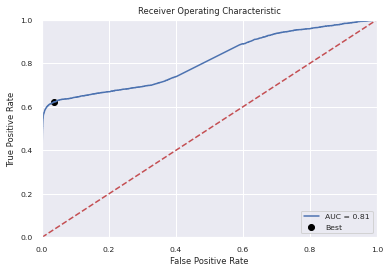

Best Threshold=0.046205, G-Mean=0.768


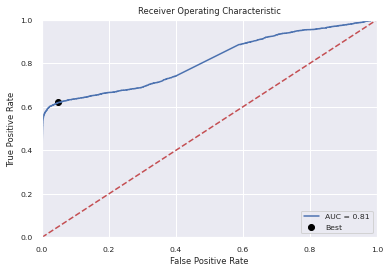

Best Threshold=0.066152, G-Mean=0.787


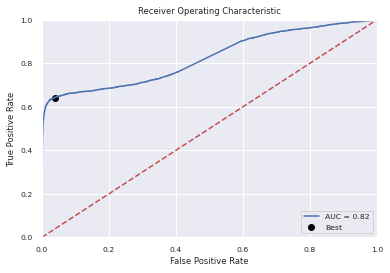

Best Threshold=0.030457, G-Mean=0.757


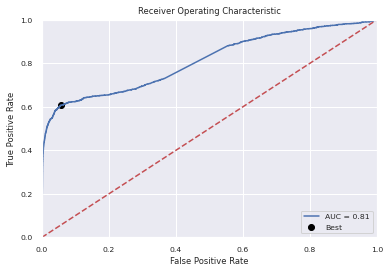

Best Threshold=0.199304, G-Mean=0.781


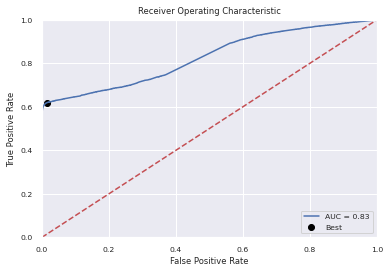

Best Threshold=0.037461, G-Mean=0.787


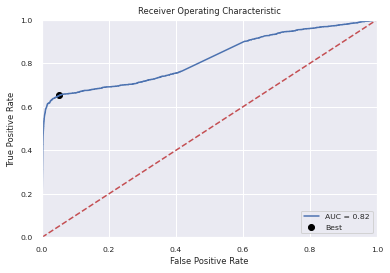

Best Threshold=0.056228, G-Mean=0.800


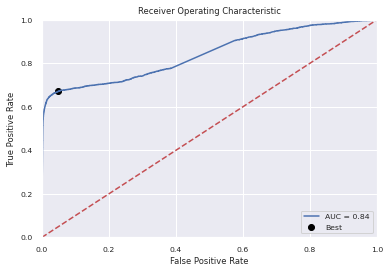

Best Threshold=0.054781, G-Mean=0.772


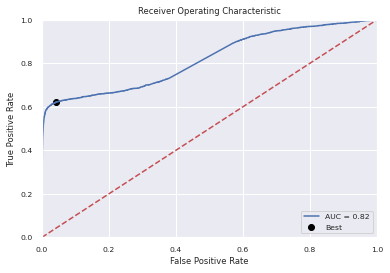

Best Threshold=0.044265, G-Mean=0.761


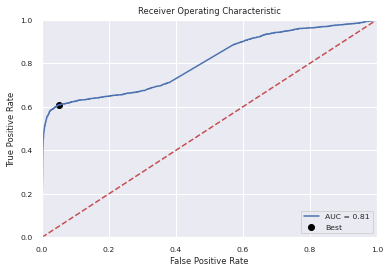

Best Threshold=0.052165, G-Mean=0.804


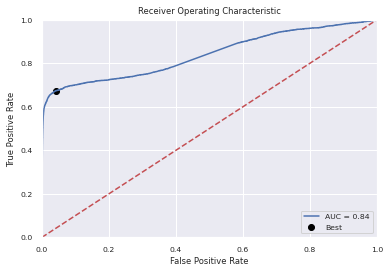

Best Threshold=0.047015, G-Mean=0.787


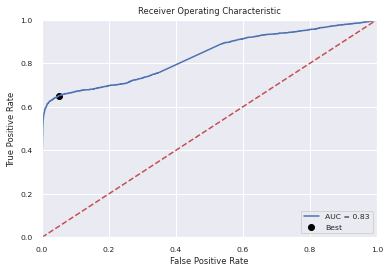

Best Threshold=0.054636, G-Mean=0.775


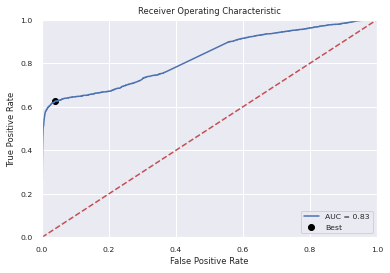

Best Threshold=0.038957, G-Mean=0.775


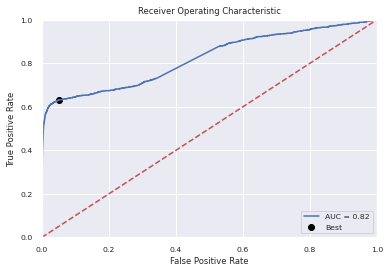

Best Threshold=0.248031, G-Mean=0.837


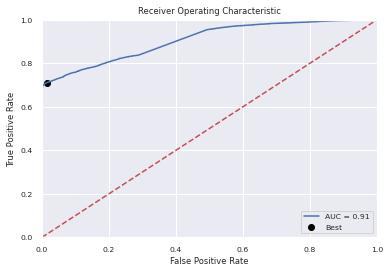

Best Threshold=0.075749, G-Mean=0.776


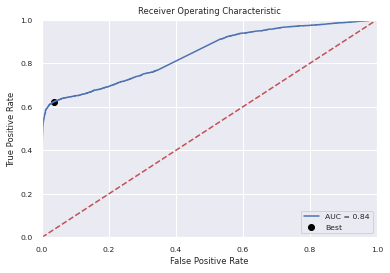

Best Threshold=0.061613, G-Mean=0.776


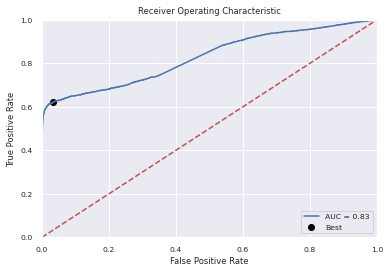

Best Threshold=0.073238, G-Mean=0.772


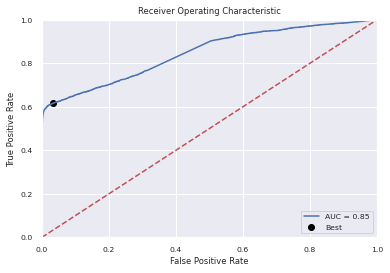

Best Threshold=0.160183, G-Mean=0.817


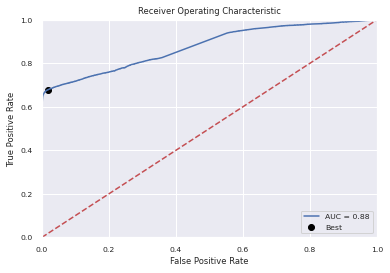

Best Threshold=0.140193, G-Mean=0.793


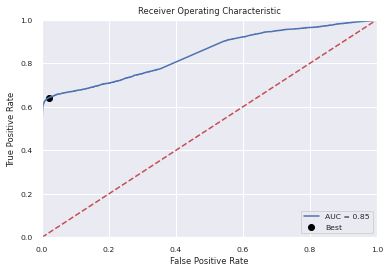

Best Threshold=0.131130, G-Mean=0.783


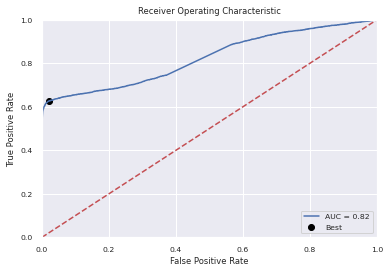

Best Threshold=0.069340, G-Mean=0.778


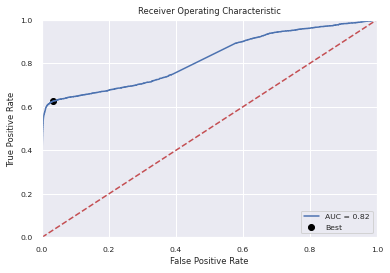

Best Threshold=0.078848, G-Mean=0.748


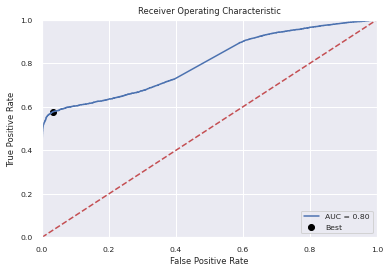

Best Threshold=0.138483, G-Mean=0.788


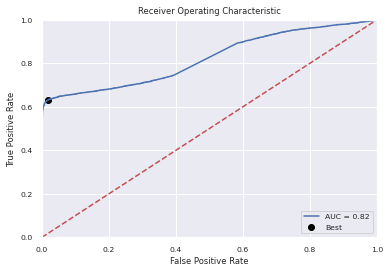

Best Threshold=0.058903, G-Mean=0.769


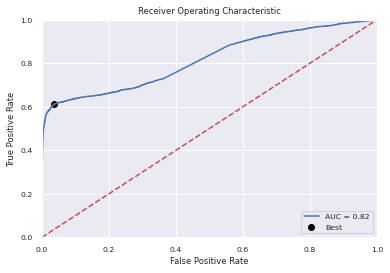

Best Threshold=0.113443, G-Mean=0.825


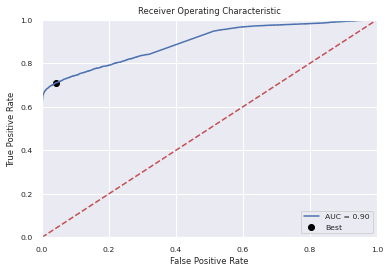

Best Threshold=0.067104, G-Mean=0.766


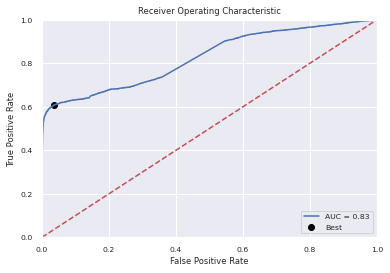

Best Threshold=0.230398, G-Mean=0.788


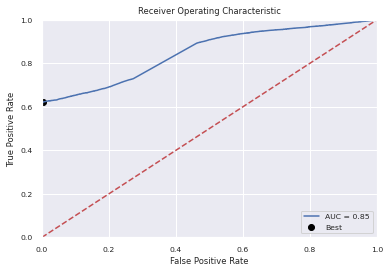

Best Threshold=0.056749, G-Mean=0.785


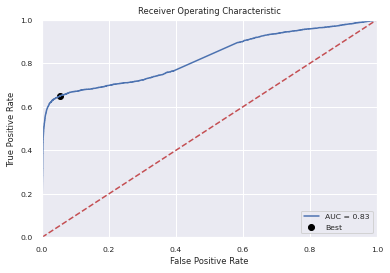

Best Threshold=0.063669, G-Mean=0.782


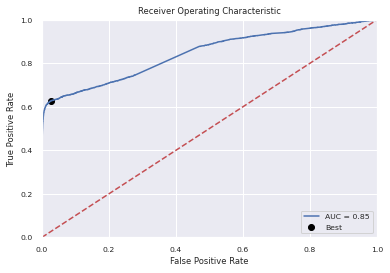

Best Threshold=0.053212, G-Mean=0.845


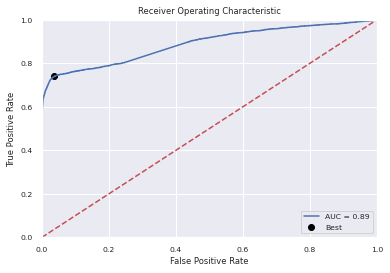

Best Threshold=0.035212, G-Mean=0.782


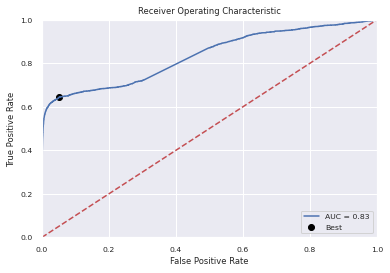

Best Threshold=0.050161, G-Mean=0.755


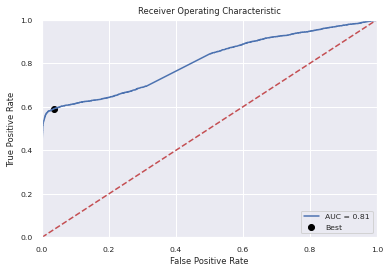

Best Threshold=0.101171, G-Mean=0.817


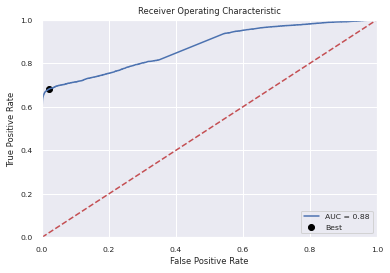

Best Threshold=0.081058, G-Mean=0.785


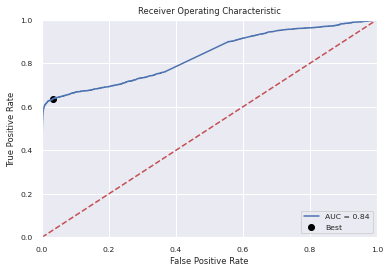

Best Threshold=0.036808, G-Mean=0.769


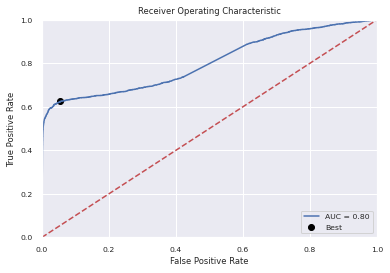

Best Threshold=0.044642, G-Mean=0.790


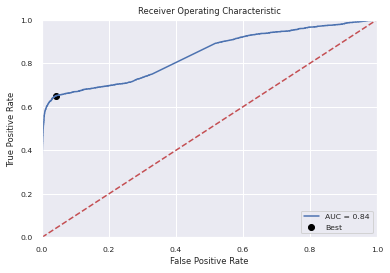

Best Threshold=0.084970, G-Mean=0.790


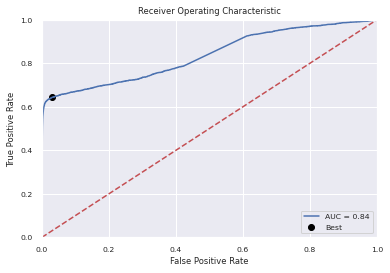

Best Threshold=0.035308, G-Mean=0.754


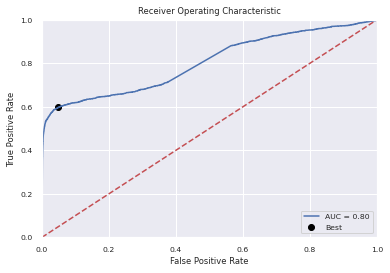

Best Threshold=0.063824, G-Mean=0.772


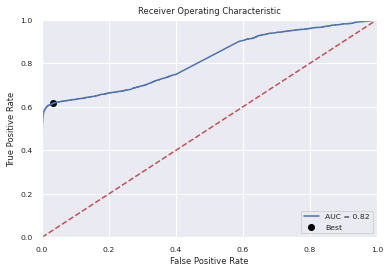

Best Threshold=0.057737, G-Mean=0.810


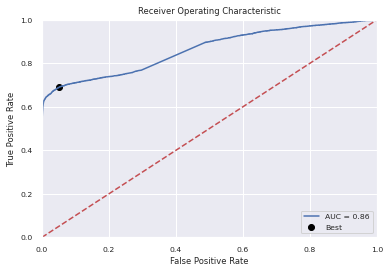

Best Threshold=0.095084, G-Mean=0.759


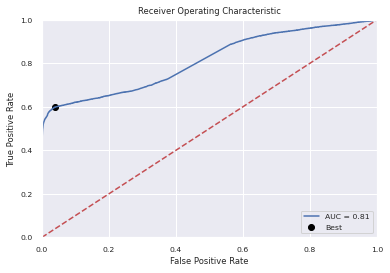

Best Threshold=0.051457, G-Mean=0.766


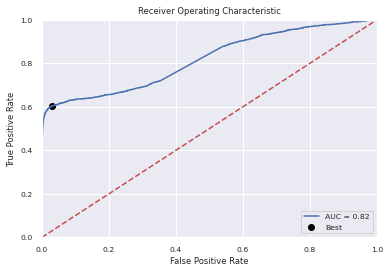

Best Threshold=0.088753, G-Mean=0.773


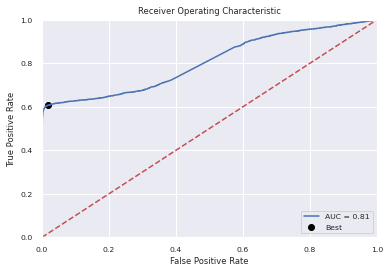

Best Threshold=0.107261, G-Mean=0.777


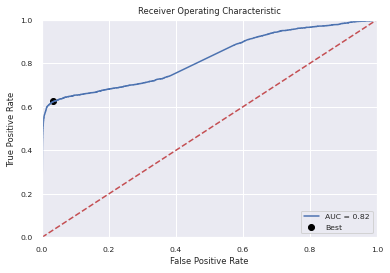

Best Threshold=0.062902, G-Mean=0.795


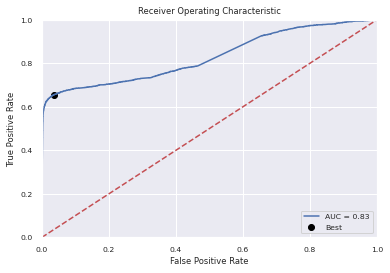

Best Threshold=0.074994, G-Mean=0.778


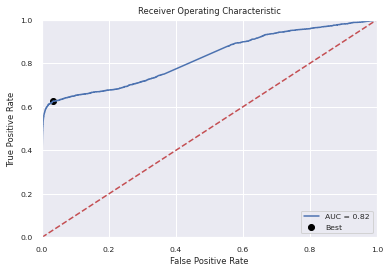

Best Threshold=0.122992, G-Mean=0.773


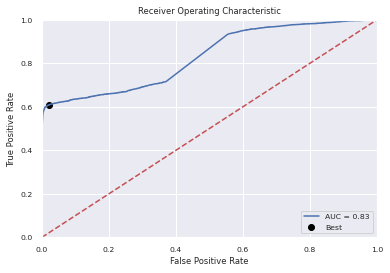

Best Threshold=0.046233, G-Mean=0.752


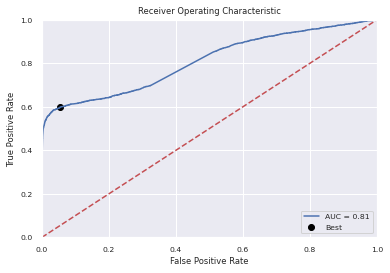

Best Threshold=0.030586, G-Mean=0.770


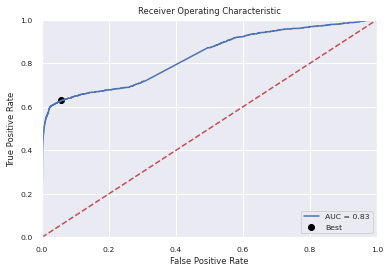

Best Threshold=0.083612, G-Mean=0.786


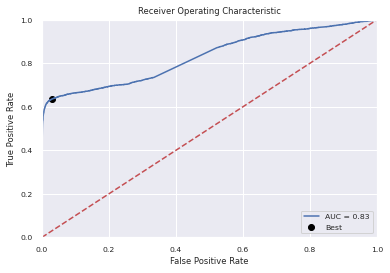

In [42]:
thresh = []
roc = []
for i in range(50):    
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), numpy_probas_test[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    roc.append(roc_auc)
    thresh.append(optimal_threshold)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [43]:
sum(roc)/50

0.8318418295263114

In [44]:
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

for i in range(50):
    numpy_probas_test[:,i] = to_labels(numpy_probas_test[:,i],thresh[i])

In [45]:
scores = []
for i in range(50):
    scores.append(binary_classification_performance(Y_test[:,i].numpy(),numpy_probas_test[:,i]))

In [46]:
f = pd.concat(scores)

In [47]:
f.mean(axis=0)

Accuracy                          0.9590
Precision (or PPV)                0.4768
Recall (senitivity or TPR)        0.6278
f1 score                          0.5240
Specificty (or TNR)               0.4768
NPV                               0.6278
True Positive                 99692.9200
True Negative                  2919.6000
False Positive                 2743.2400
False Negative                 1661.2400
dtype: float64

In [48]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test.numpy(), numpy_probas_test)

array([[[ 99983,   2338],
        [  1820,   2876]],

       [[101455,   2490],
        [  1221,   1851]],

       [[101145,   2590],
        [  1203,   2079]],

       [[ 99344,   5729],
        [   767,   1177]],

       [[ 93219,    989],
        [  4924,   7885]],

       [[101461,   3545],
        [   726,   1285]],

       [[100378,   3449],
        [  1083,   2107]],

       [[100471,   3094],
        [  1337,   2115]],

       [[100029,   4514],
        [   981,   1493]],

       [[ 98668,   3839],
        [  1483,   3027]],

       [[100197,   3927],
        [  1037,   1856]],

       [[101530,   3175],
        [   883,   1429]],

       [[102369,   2830],
        [   704,   1114]],

       [[ 85778,    703],
        [  6043,  14493]],

       [[100276,   3391],
        [  1267,   2083]],

       [[101517,   2328],
        [  1220,   1952]],

       [[100249,   2111],
        [  1823,   2834]],

       [[ 95576,   1299],
        [  3290,   6852]],

       [[ 98797,   1593],
  

# Binary Logits

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [50]:
#Converting engagement frequencies from tensor to numpy array

X_freq_1 = X_freq.numpy()
X_freq_1_test = X_freq_test.numpy()


In [51]:
empty_train_p = []
empty_test_p = []
for i in range(50):
    recent_lm_train = X_recent_2[:,[i,i+50,i+100,i+150]]     #Engagement history by topic as input for training
    freq_lm_train = X_freq_1[:,i]                            #Engagement frequncy by topic as input for training
    recommend_lm_train = X_recommend_1[:,i]                  #Recommendations by topic as input for training
    
    recent_lm_test = X_recent_2_test[:,[i,i+50,i+100,i+150]] #Engagement history by topic as input for testing
    freq_lm_test = X_freq_1_test[:,i]                        #Engagement frequncy by topic as input for testing
    recommend_lm_test = X_recommend_t[:,i]                   #Recommendations by topic as input for testing


    y_lm_train = y_1[:,i]                                    #Engagement labels

    X = np.column_stack([recent_lm_train,freq_lm_train,recommend_lm_train])  #Concatenated input features for training

    #LR = LogisticRegression(class_weight="balanced")
    LR = LogisticRegression()

    LR.fit(X,y_lm_train)
    
    X_test = np.column_stack([recent_lm_test,freq_lm_test,recommend_lm_test]) #Concatenated input features for testing
    
    empty_train_p.append((LR.predict_proba(X)[:,1]))
       
    empty_test_p.append((LR.predict_proba(X_test)[:,1]))
      

In [52]:
prediction_lr_train_p = np.transpose(np.array(empty_train_p))  #Predictions for training data
prediction_lr_test_p = np.transpose(np.array(empty_test_p))    #Predictions for test data

In [53]:
from sklearn.metrics import log_loss
log_loss(y_t,prediction_lr_test_p)

4.871892617844867

Best Threshold=0.991032, G-Mean=0.794


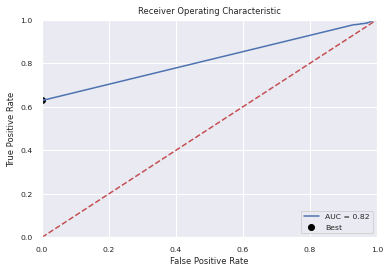

Best Threshold=0.014330, G-Mean=0.798


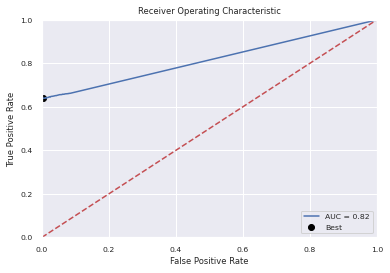

Best Threshold=0.013598, G-Mean=0.808


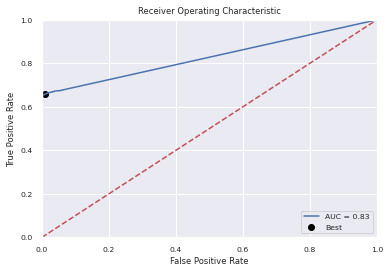

Best Threshold=0.007940, G-Mean=0.798


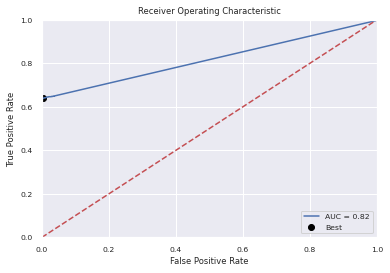

Best Threshold=0.997508, G-Mean=0.794


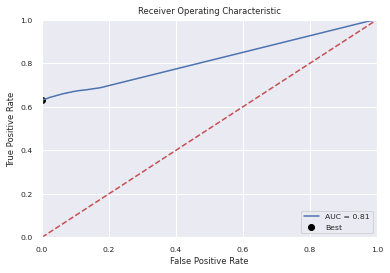

Best Threshold=0.979785, G-Mean=0.807


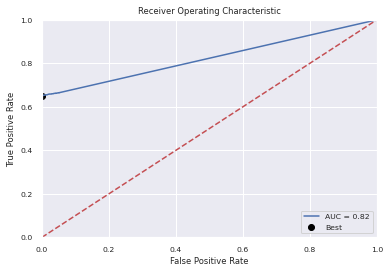

Best Threshold=0.993759, G-Mean=0.817


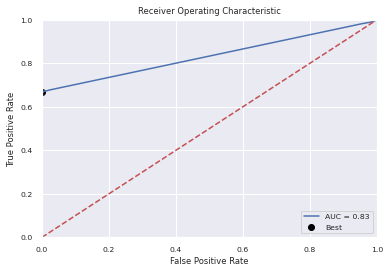

Best Threshold=0.992956, G-Mean=0.791


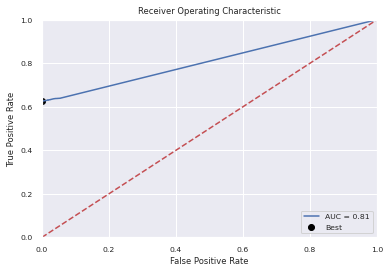

Best Threshold=0.009349, G-Mean=0.789


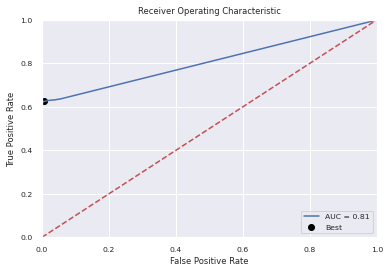

Best Threshold=0.989011, G-Mean=0.832


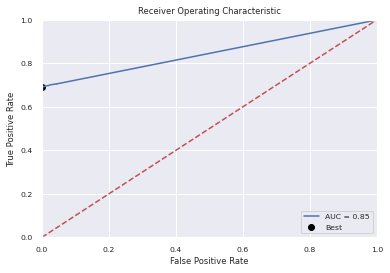

Best Threshold=0.989814, G-Mean=0.810


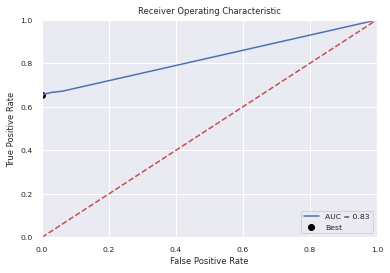

Best Threshold=0.008094, G-Mean=0.796


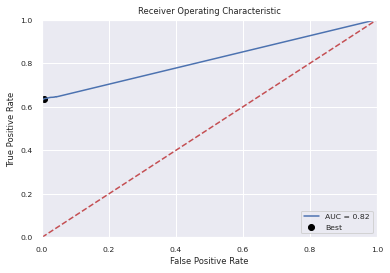

Best Threshold=0.986972, G-Mean=0.801


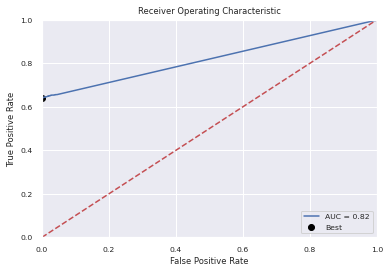

Best Threshold=0.096907, G-Mean=0.846


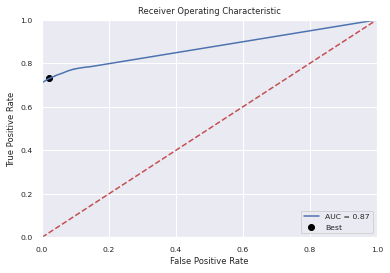

Best Threshold=0.017850, G-Mean=0.805


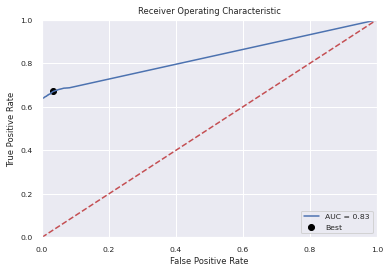

Best Threshold=0.013746, G-Mean=0.808


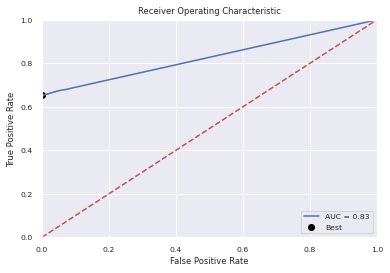

Best Threshold=0.021569, G-Mean=0.803


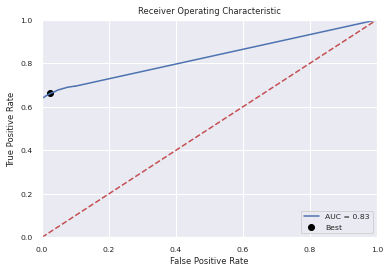

Best Threshold=0.035188, G-Mean=0.828


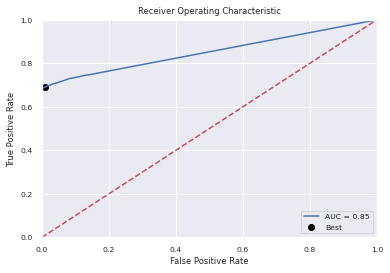

Best Threshold=0.035678, G-Mean=0.812


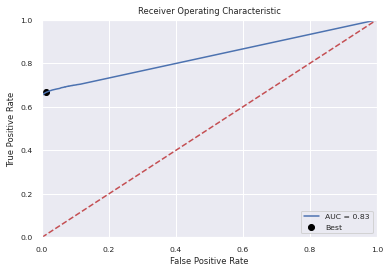

Best Threshold=0.995514, G-Mean=0.802


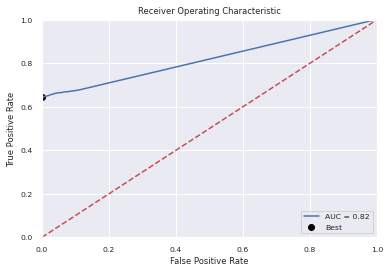

Best Threshold=0.008513, G-Mean=0.799


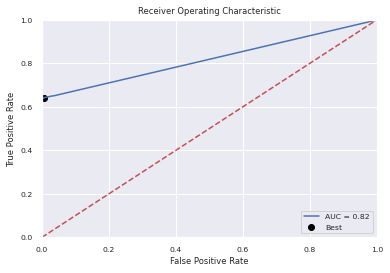

Best Threshold=0.020464, G-Mean=0.784


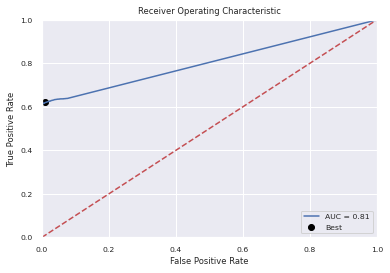

Best Threshold=0.027642, G-Mean=0.803


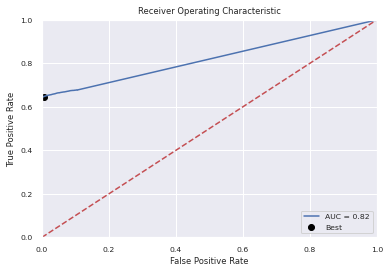

Best Threshold=0.007578, G-Mean=0.798


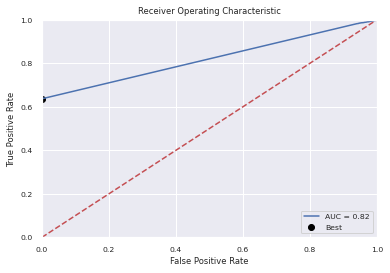

Best Threshold=0.048619, G-Mean=0.838


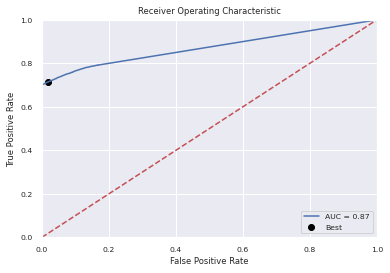

Best Threshold=0.021242, G-Mean=0.800


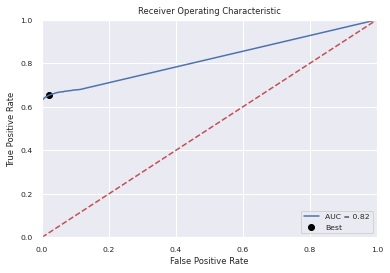

Best Threshold=0.997281, G-Mean=0.791


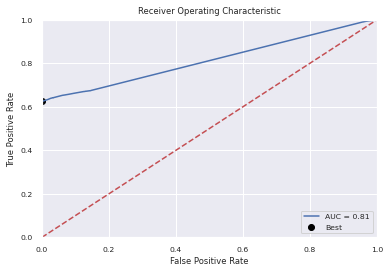

Best Threshold=0.015556, G-Mean=0.813


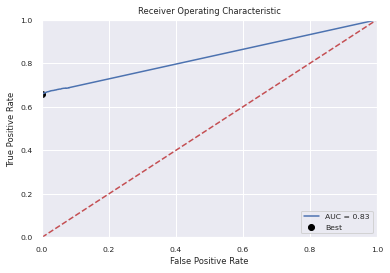

Best Threshold=0.986380, G-Mean=0.816


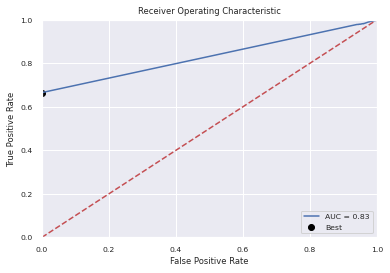

Best Threshold=0.039762, G-Mean=0.873


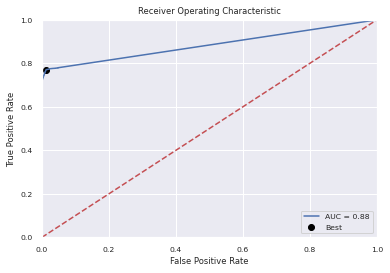

Best Threshold=0.988677, G-Mean=0.815


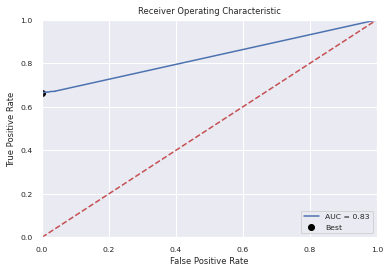

Best Threshold=0.008115, G-Mean=0.787


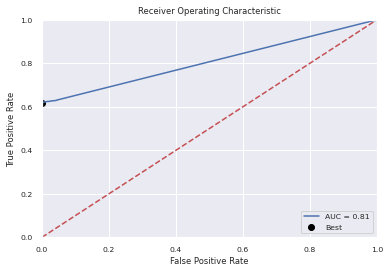

Best Threshold=0.023606, G-Mean=0.831


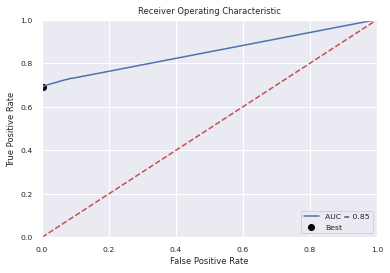

Best Threshold=0.018080, G-Mean=0.807


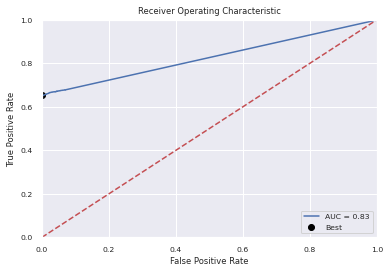

Best Threshold=0.984969, G-Mean=0.796


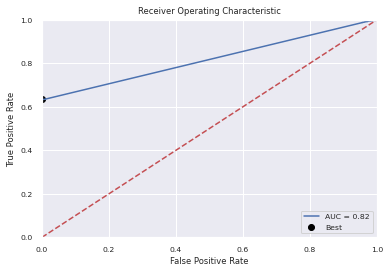

Best Threshold=0.989197, G-Mean=0.820


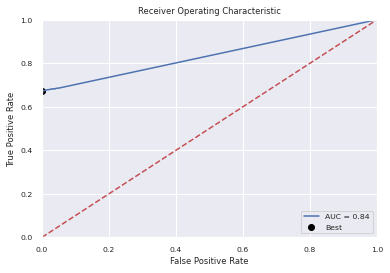

Best Threshold=0.014468, G-Mean=0.804


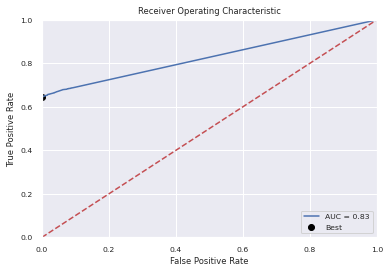

Best Threshold=0.007226, G-Mean=0.785


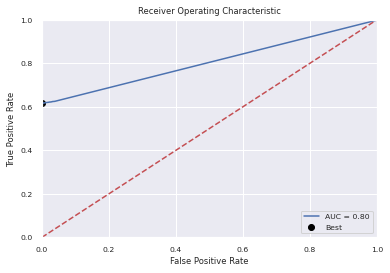

Best Threshold=0.015074, G-Mean=0.788


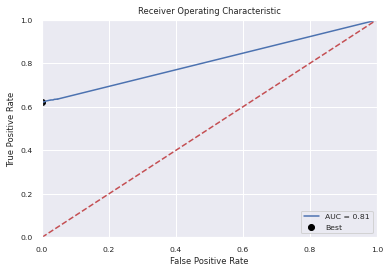

Best Threshold=0.028863, G-Mean=0.835


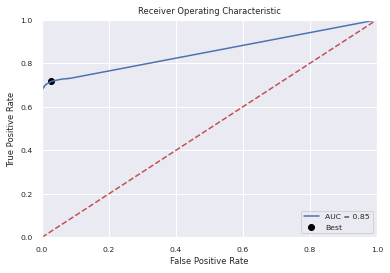

Best Threshold=0.035766, G-Mean=0.789


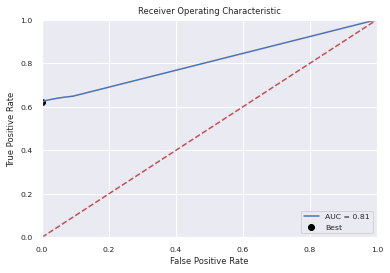

Best Threshold=0.987874, G-Mean=0.793


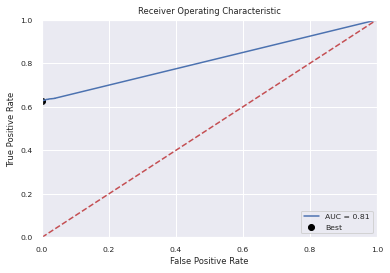

Best Threshold=0.012004, G-Mean=0.784


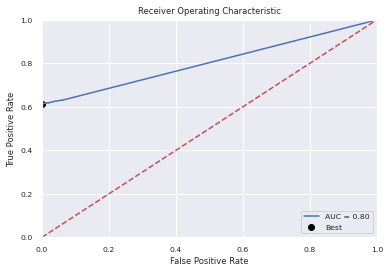

Best Threshold=0.992912, G-Mean=0.799


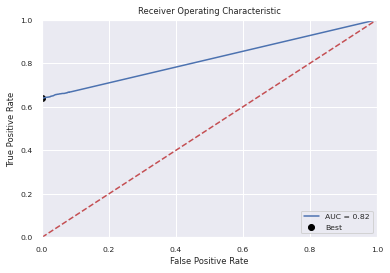

Best Threshold=0.012370, G-Mean=0.816


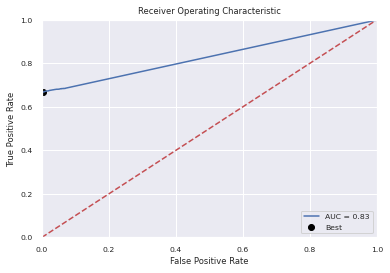

Best Threshold=0.989742, G-Mean=0.802


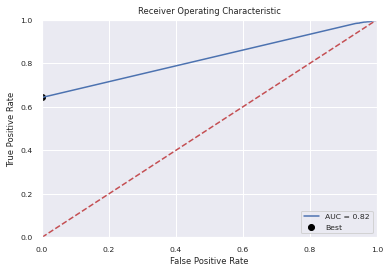

Best Threshold=0.029022, G-Mean=0.800


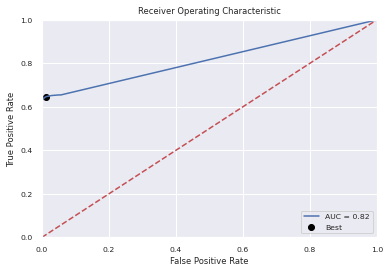

Best Threshold=0.008943, G-Mean=0.790


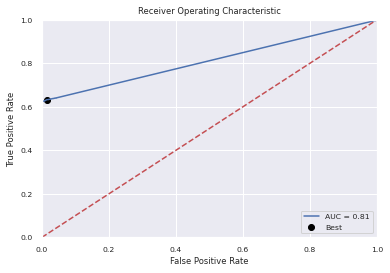

Best Threshold=0.007244, G-Mean=0.802


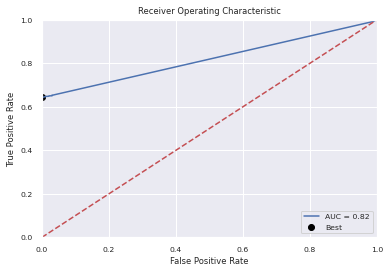

Best Threshold=0.018663, G-Mean=0.807


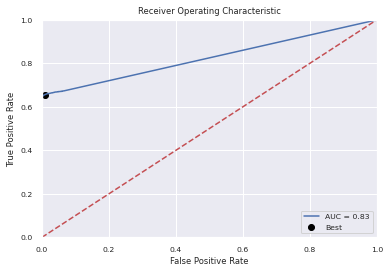

In [54]:
thresh_lr = []
roc_lr = []
for i in range(50):    
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), prediction_lr_test_p[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    thresh_lr.append(optimal_threshold)
    roc_lr.append(roc_auc)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [55]:
sum(roc_lr)/50  #Average AUC-ROC score 

0.8258854966844916

In [56]:
prediction_lr_test_p.shape

(107017, 50)

In [57]:
label_lr_test_p = np.empty([107017, 50])
for i in range(50):
    label_lr_test_p[:,i] = to_labels(prediction_lr_test_p[:,i],thresh_lr[i])

In [58]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(Y_test.numpy(), label_lr_test_p)


array([[[102321,      0],
        [  1735,   2961]],

       [[103943,      2],
        [  1114,   1958]],

       [[103735,      0],
        [  1146,   2136]],

       [[105073,      0],
        [   705,   1239]],

       [[ 94208,      0],
        [  4731,   8078]],

       [[105006,      0],
        [   700,   1311]],

       [[103827,      0],
        [  1060,   2130]],

       [[103565,      0],
        [  1290,   2162]],

       [[104520,     23],
        [   937,   1537]],

       [[102507,      0],
        [  1390,   3120]],

       [[104124,      0],
        [   997,   1896]],

       [[104705,      0],
        [   852,   1460]],

       [[105199,      0],
        [   652,   1166]],

       [[ 86063,    418],
        [  5839,  14697]],

       [[103393,    274],
        [  1205,   2145]],

       [[103813,     32],
        [  1103,   2069]],

       [[102360,      0],
        [  1675,   2982]],

       [[ 96858,     17],
        [  3207,   6935]],

       [[ 99341,   1049],
  

In [59]:
scores_lr = []
for i in range(50):
    scores_lr.append(binary_classification_performance(Y_test[:,i].numpy(),label_lr_test_p[:,i]))

In [60]:
f_lr = pd.concat(scores_lr)

In [61]:
f_lr.mean(axis=0)

Accuracy                           0.9834
Precision (or PPV)                 0.9586
Recall (senitivity or TPR)         0.6502
f1 score                           0.7718
Specificty (or TNR)                0.9586
NPV                                0.6502
True Positive                 102274.5000
True Negative                   3010.3400
False Positive                   161.6600
False Negative                  1570.5000
dtype: float64

# Light GBM model

In [62]:
!pip install lightgbm

In [63]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



In [64]:
empty_train_1p = []
empty_test_1p = []


for i in range(50):
    recent_lm_train = X_recent_2[:,[i,i+50,i+100,i+150]]
    freq_lm_train = X_freq_1[:,i]
    recommend_lm_train = X_recommend_1[:,i]
    
    recent_lm_test = X_recent_2_test[:,[i,i+50,i+100,i+150]]
    freq_lm_test = X_freq_1_test[:,i]
    recommend_lm_test = X_recommend_t[:,i]


    y_lm_train = y_1[:,i]
    

    X = np.column_stack([recent_lm_train,freq_lm_train,recommend_lm_train])

    LGBM = LGBMClassifier()

    LGBM.fit(X,y_lm_train)
    
    X_test = np.column_stack([recent_lm_test,freq_lm_test,recommend_lm_test])
    
    empty_train_1p.append((LGBM.predict_proba(X)[:,1]))

    empty_test_1p.append((LGBM.predict_proba(X_test)[:,1]))
        


In [65]:
prediction_lgbm_train_p = np.transpose(np.array(empty_train_1p))
prediction_lgbm_test_p = np.transpose(np.array(empty_test_1p))

In [66]:
from sklearn.metrics import log_loss
log_loss(Y_test.numpy(),prediction_lgbm_test_p)

4.947469480496386

0.9999699101278051
Best Threshold=0.053943, G-Mean=0.794


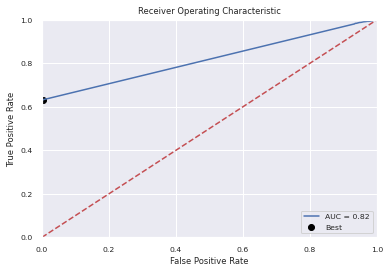

0.9999837846001198
Best Threshold=0.999984, G-Mean=0.798


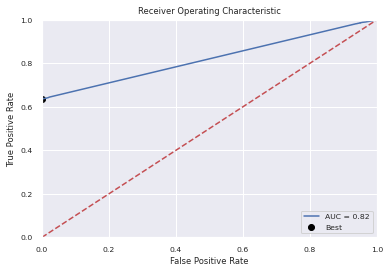

0.08071900050272991
Best Threshold=0.080719, G-Mean=0.807


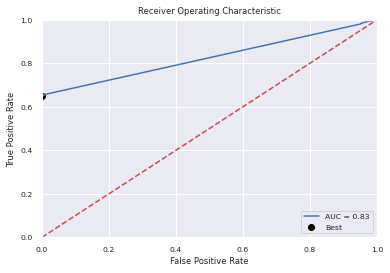

0.4965572049241403
Best Threshold=0.496557, G-Mean=0.799


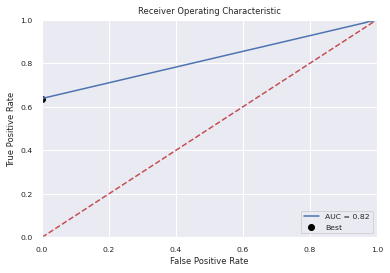

0.9999643481465509
Best Threshold=0.218449, G-Mean=0.794


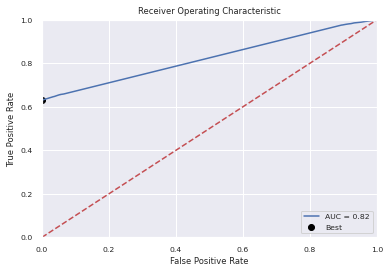

0.9999944483095032
Best Threshold=0.999994, G-Mean=0.807


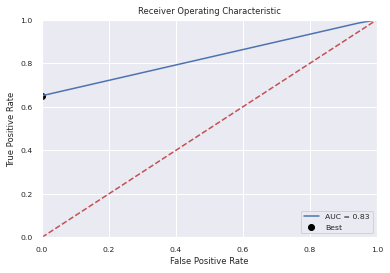

0.9999802123161287
Best Threshold=0.999980, G-Mean=0.817


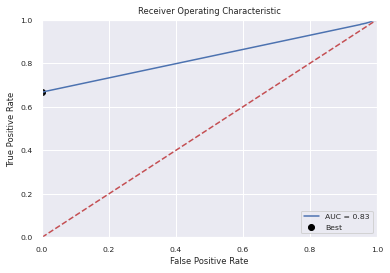

0.10468262869725481
Best Threshold=0.104683, G-Mean=0.792


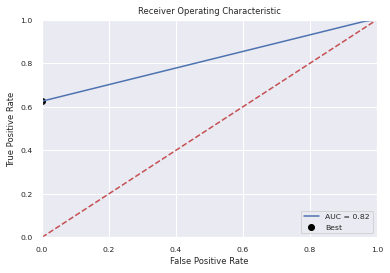

0.9999899033662897
Best Threshold=0.999990, G-Mean=0.788


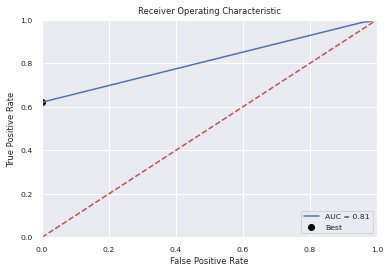

0.9999829796435405
Best Threshold=0.999983, G-Mean=0.832


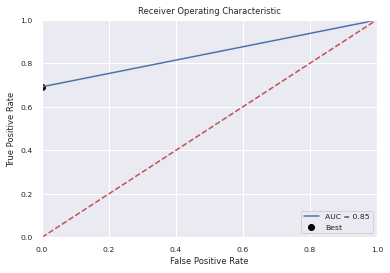

0.9999826379349522
Best Threshold=0.056423, G-Mean=0.810


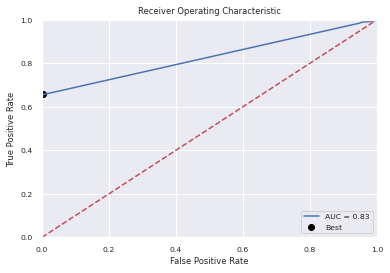

0.9999881207793837
Best Threshold=0.999988, G-Mean=0.795


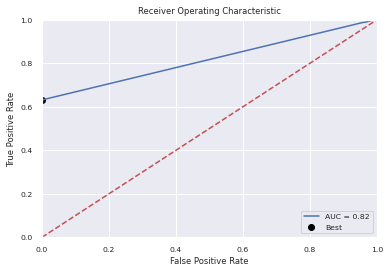

0.9997686777596714
Best Threshold=0.999769, G-Mean=0.801


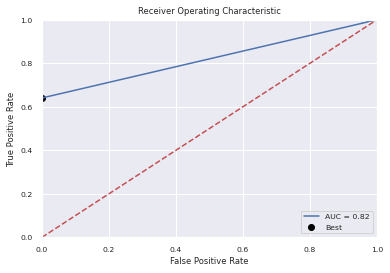

0.20627455453528
Best Threshold=0.106112, G-Mean=0.846


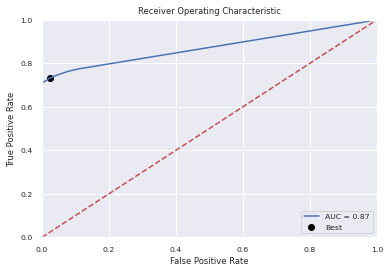

0.06002395646851241
Best Threshold=0.010017, G-Mean=0.802


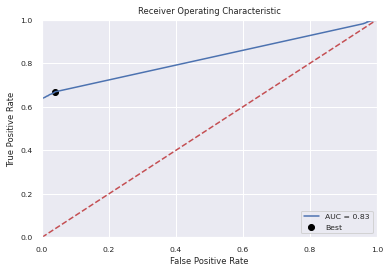

0.9999553220571064
Best Threshold=0.999955, G-Mean=0.807


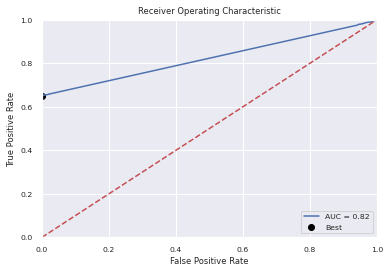

0.1180371889389687
Best Threshold=0.015463, G-Mean=0.802


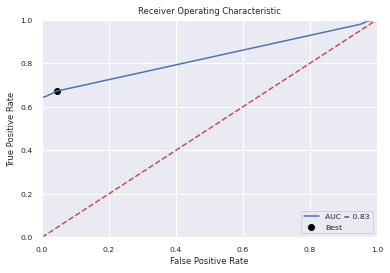

0.9999650347701685
Best Threshold=0.080030, G-Mean=0.827


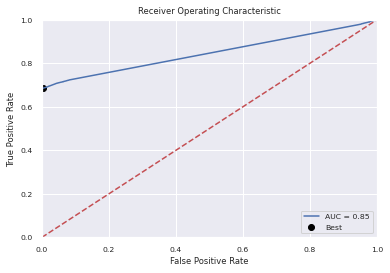

0.08650749867347486
Best Threshold=0.031383, G-Mean=0.809


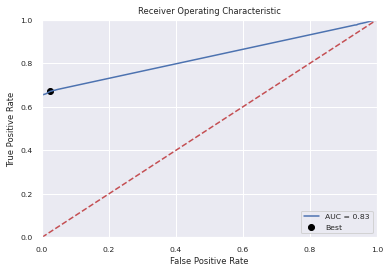

0.13762203243336582
Best Threshold=0.137622, G-Mean=0.802


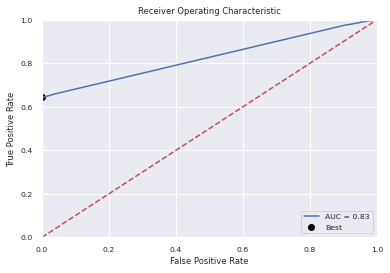

0.9999599609019467
Best Threshold=0.999960, G-Mean=0.799


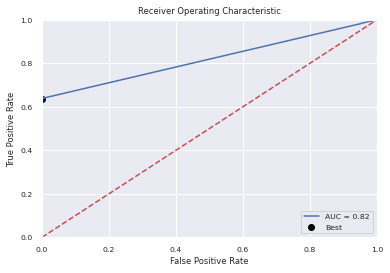

0.09851240362869253
Best Threshold=0.098512, G-Mean=0.783


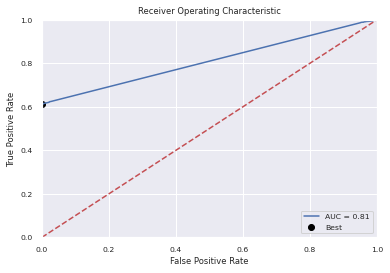

0.9999684551066702
Best Threshold=0.999968, G-Mean=0.803


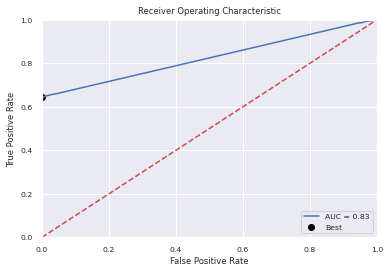

0.3175363801700661
Best Threshold=0.317536, G-Mean=0.798


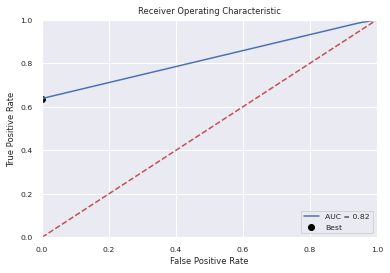

0.17025273368530286
Best Threshold=0.098971, G-Mean=0.838


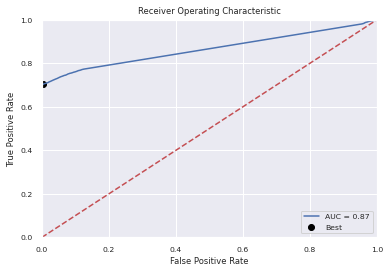

0.08464407393981291
Best Threshold=0.032649, G-Mean=0.796


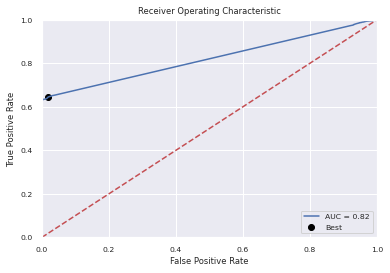

0.17828239128700896
Best Threshold=0.168648, G-Mean=0.791


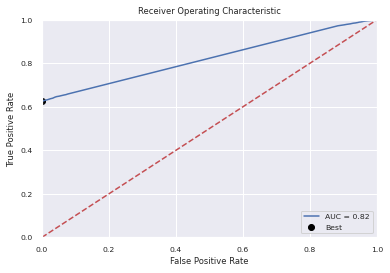

0.999976885585561
Best Threshold=0.093663, G-Mean=0.813


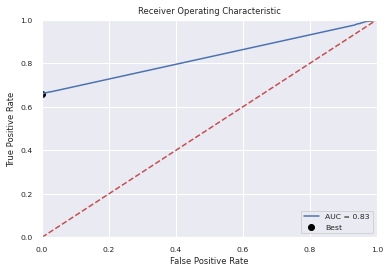

0.9999863453141778
Best Threshold=0.999986, G-Mean=0.816


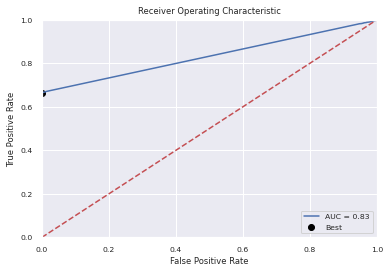

0.005970965529043893
Best Threshold=0.005971, G-Mean=0.868


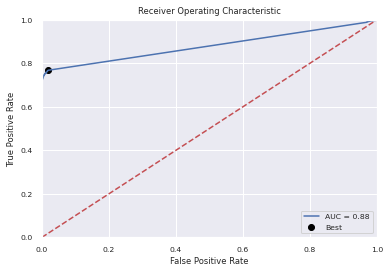

0.9999472618310999
Best Threshold=0.999947, G-Mean=0.815


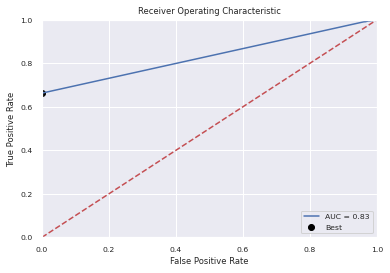

0.9997956155153209
Best Threshold=0.999796, G-Mean=0.786


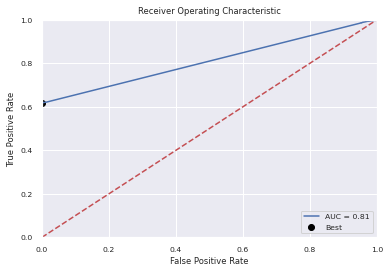

0.192259158343645
Best Threshold=0.192259, G-Mean=0.831


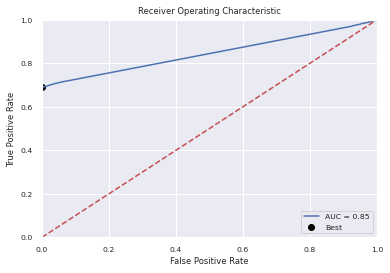

0.08406808804401594
Best Threshold=0.084068, G-Mean=0.807


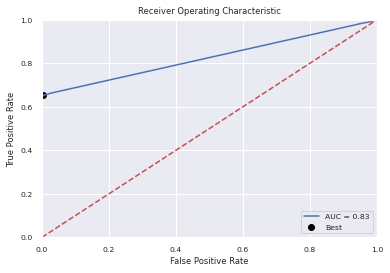

0.9999923545143461
Best Threshold=0.073263, G-Mean=0.796


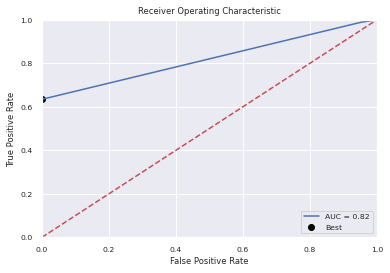

0.06096000109096539
Best Threshold=0.060960, G-Mean=0.821


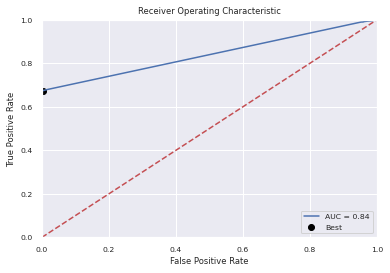

0.5121036669057667
Best Threshold=0.512104, G-Mean=0.804


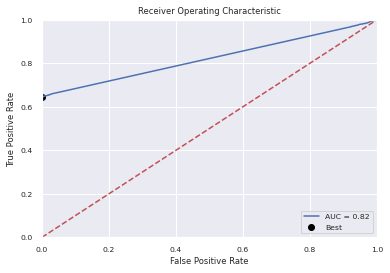

0.9999940775717172
Best Threshold=0.999994, G-Mean=0.784


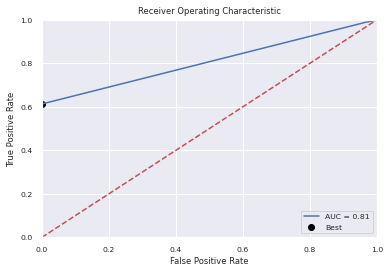

0.9999847871990328
Best Threshold=0.999985, G-Mean=0.788


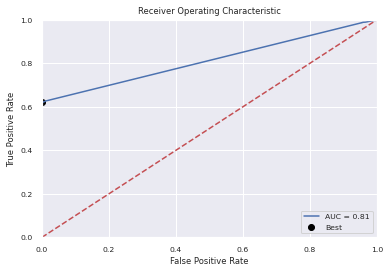

0.08822832470316198
Best Threshold=0.033785, G-Mean=0.832


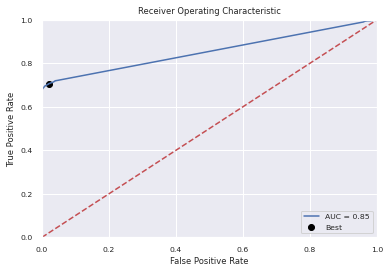

0.9999657347475833
Best Threshold=0.999966, G-Mean=0.789


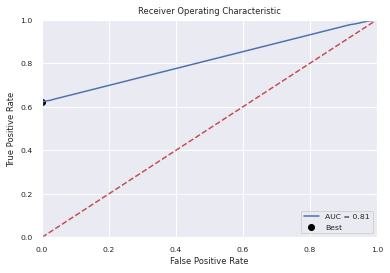

0.23405900902969942
Best Threshold=0.019415, G-Mean=0.793


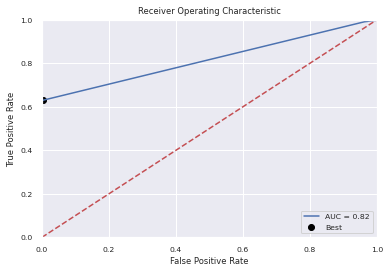

0.9999795564511782
Best Threshold=0.999980, G-Mean=0.783


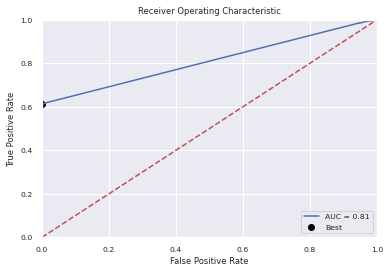

0.9999713538380929
Best Threshold=0.999971, G-Mean=0.799


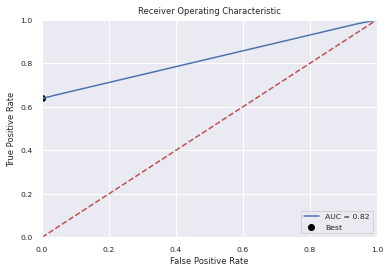

0.1144480138659435
Best Threshold=0.114448, G-Mean=0.816


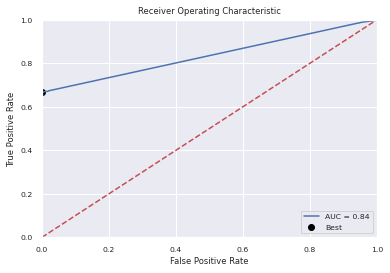

0.9999773104703891
Best Threshold=0.999977, G-Mean=0.802


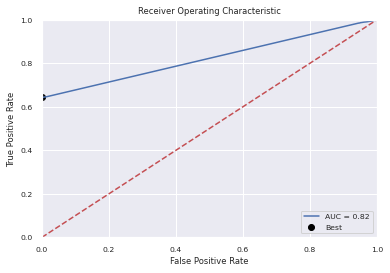

0.025612476832920353
Best Threshold=0.025612, G-Mean=0.797


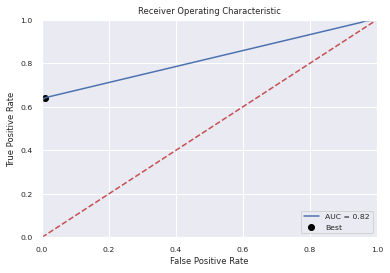

0.08004145230033928
Best Threshold=0.064430, G-Mean=0.790


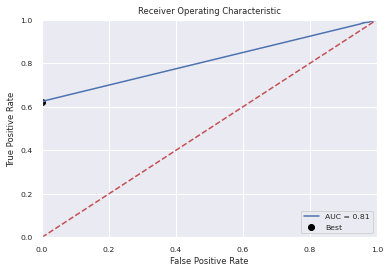

0.9984690956634376
Best Threshold=0.058139, G-Mean=0.802


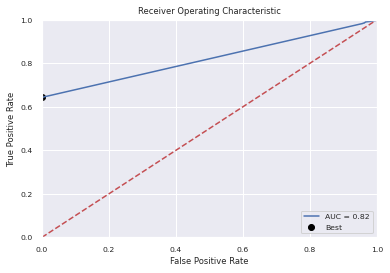

0.13397844413194443
Best Threshold=0.016998, G-Mean=0.805


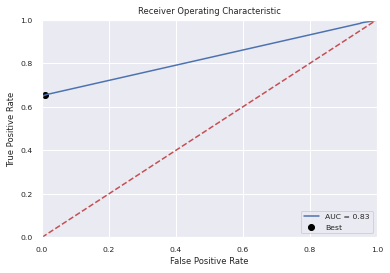

In [67]:
thresh_lgbm = []
roc_lgbm = []
for i in range(50):    
    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    #probs = model.predict_proba(X_test)
    #preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(Y_test[:,i].numpy(), prediction_lgbm_test_p[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    print(optimal_threshold)
    thresh_lgbm.append(optimal_threshold)
    roc_lgbm.append(roc_auc)
    
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

In [68]:
sum(roc_lgbm)/50

0.8273313144877251

In [69]:
label_lgbm_test_p = np.empty([107017, 50])
for i in range(50):
    label_lgbm_test_p[:,i] = to_labels(prediction_lgbm_test_p[:,i],thresh_lgbm[i])

In [70]:
multilabel_confusion_matrix(Y_test.numpy(), label_lgbm_test_p)

array([[[102321,      0],
        [  1735,   2961]],

       [[103945,      0],
        [  1115,   1957]],

       [[103637,     98],
        [  1142,   2140]],

       [[105068,      5],
        [   704,   1240]],

       [[ 94208,      0],
        [  4731,   8078]],

       [[105006,      0],
        [   700,   1311]],

       [[103827,      0],
        [  1060,   2130]],

       [[103510,     55],
        [  1288,   2164]],

       [[104543,      0],
        [   938,   1536]],

       [[102507,      0],
        [  1390,   3120]],

       [[104124,      0],
        [   997,   1896]],

       [[104705,      0],
        [   852,   1460]],

       [[105199,      0],
        [   652,   1166]],

       [[ 86332,    149],
        [  5924,  14612]],

       [[103233,    434],
        [  1201,   2149]],

       [[103845,      0],
        [  1104,   2068]],

       [[102236,    124],
        [  1665,   2992]],

       [[ 96875,      0],
        [  3210,   6932]],

       [[100074,    316],
  

In [71]:
scores_lgbm = []
for i in range(50):
    scores_lgbm.append(binary_classification_performance(Y_test[:,i].numpy(),label_lgbm_test_p[:,i]))

In [72]:
f_lgbm = pd.concat(scores_lgbm)

In [73]:
f_lgbm.mean(axis=0)

Accuracy                           0.9840
Precision (or PPV)                 0.9682
Recall (senitivity or TPR)         0.6490
f1 score                           0.7754
Specificty (or TNR)                0.9682
NPV                                0.6490
True Positive                 102315.2400
True Negative                   3004.4200
False Positive                   120.9200
False Negative                  1576.4200
dtype: float64

# Exhaustive search for Optimization

In [74]:
x = pd.DataFrame(X_recommend_t)
x.sum(axis=1).value_counts()
x['Total'] = x.sum(axis=1)
y=x[x['Total'] >= 6] #Considering only the users who are shown atleast six tweets
#del y['Total']

infinity = pd.DataFrame(X_freq_1_test)
histo = pd.DataFrame(X_recent_2_test)

inf_new=infinity.loc[y.index,:]
hist_new=histo.loc[y.index,:]

In [75]:

def dfs(x,start,end,cnt,l_):
    if start==end:
        return []
    if cnt==5:
        ans.append(l_)
        return 
    
    for i in range(start,end):
        if int(x[i])==1:           
            dfs(x,i+1,end,cnt+1,l_+[i])
                    
d={}
cnt={}
v={}
for i in y.index:
    p=y.loc[i,:]
    l=list(p)
    ans=[]
    dfs(l,0,len(l),0,[])

    v[i]=ans
    for m in range(len(ans)):
        n=[0]*50
        for k in range(len(ans[m])):
            n[ans[m][k]]=1
        if i not in d:
            d[i]=[]
        d[i].append(n)


In [76]:
global_l=[]    
for i in d:
    for x in d[i]:
        global_l.append([i]+x)

#Dataframe enumerating all the possible recommendation scenarios for all the users.
global_df=pd.DataFrame(global_l,columns=['User']+[i for i in range(50)]).set_index('User')         

In [77]:
opt_rec = global_df 
opt_freq =inf_new.loc[global_df.index]   
opt_hist = hist_new.loc[global_df.index]

In [78]:
#Converting all the dataframes to tensors.
opt_freq_T = torch.FloatTensor(opt_freq.values)
opt_hist_T = torch.FloatTensor(opt_hist.values.reshape(-1,50,4))
opt_rec_T = torch.FloatTensor(opt_rec.values)
opt_indicator_T = torch.ones([505809, 50])

In [79]:
test_dataset = TensorDataset(opt_freq_T, opt_hist_T, opt_rec_T, opt_indicator_T)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle = False)

In [80]:
probas_opt = []
import time
start_time = time.time()
counter = 0

for step_num, batch_data in enumerate(test_dataloader):
        freq, recent, recommend, indicator = tuple(t.to(device)for t in batch_data)
        logits_opt = model(freq, recent, recommend, indicator)
        numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
        numpy_probas_opt = sigmoid_v(numpy_logits_opt)
        probas_opt.append(pd.DataFrame(numpy_probas_opt).round(decimals=6))
        counter = counter + 1
print(counter)        
print("--- %s seconds ---" % (time.time() - start_time)) 

15807
--- 118.76264333724976 seconds ---


In [81]:
fins = pd.concat(probas_opt)
fins = fins*opt_rec.values

In [82]:
scor = pd.DataFrame()
scor['total'] = fins.sum(axis = 1)
scor['user'] = global_df.index
scor.index = global_df.index

In [83]:
opt_rec_T_F = global_df
opt_rec_T_F['prob'] = scor['total']
opt_rec_T_F['ind'] = scor['user']
lp = opt_rec_T_F.sort_values('prob', ascending=False).drop_duplicates(['ind'])
mp= lp.reindex(y.index)

In [84]:
mp['prob'].mean()

4.282767521098836

In [85]:
#del lp['prob']
#del lp['ind']

In [86]:
lr_p = pd.DataFrame(prediction_lgbm_test_p)
lr_ding = lr_p.loc[y.index]
p=lr_ding*y.iloc[:,0:50].values


In [87]:
s=pd.DataFrame(np.zeros((p.shape[0],p.shape[1]))).set_index(p.index)
for ind in p.index:
    s.loc[ind,p.loc[ind].nlargest(5).index.values]=1
s_=s.reset_index() 

In [88]:
opt_rec_=opt_rec.reset_index().rename(columns={'User':'index'})
#col=opt_rec.columns
final=pd.merge(s_,opt_rec_,on=list(s_.columns),how='left').reset_index(drop=True).set_index('index')


In [89]:
final['prob'].mean()

2.8972059459076767

In [90]:
s_.index = s_['index']
del s_['index']
inf_new_T = torch.FloatTensor(inf_new.values)
hist_new_T = torch.FloatTensor(hist_new.values.reshape(-1,50,4))
rec_T = torch.FloatTensor(s_.values)
indicator_T = torch.ones([3531, 50])
logits_opt = model(inf_new_T.to(device), hist_new_T.to(device), rec_T.to(device), indicator_T.to(device))
numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
numpy_probas_opt = sigmoid_v(numpy_logits_opt)
sp = pd.DataFrame(numpy_probas_opt, index = y.index)
sc = sp*s_.values

# Greedy Search

In [91]:
def greedy(freq, hist, y):
    empty =[]
    for user in range(y.shape[0]):
        s=set()
        for i,x in enumerate(y.iloc[user]):
            if x==1.0:
                s.add(i)
        output=[[0.0]*50]
        removed=set()
        l_=[]

        for j in range(5):
            ma=-float('inf')
            for i in s:
                l_.append(i)

                output[0][i]=1.0
                inf_new_ = torch.FloatTensor(freq.iloc[user].values).reshape(1,50)
                hist_new_ = torch.FloatTensor(hist.iloc[user].values.reshape(-1,50,4))
                y_ = torch.FloatTensor(np.array(output[0])).reshape(1,50)
                indicator = torch.ones([50]).reshape(1,50)    
                logits_opt = model(inf_new_.to(device), hist_new_.to(device), y_.to(device), indicator.to(device))
                numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
                numpy_probas_opt = sigmoid_v(numpy_logits_opt)
                sum_=sum(numpy_probas_opt[0][k] for k in l_)
                if sum_>ma:
                    result_l=l_[:]
                    numpy_logits_opt_max=numpy_logits_opt
                    numpy_probas_opt_max=numpy_probas_opt
                    ma=sum_
                    index=i
                l_.pop()
                output[0][i]=0.0

            output[0][index]=1.0
            l_.append(index)

            s.remove(index)
        empty.append([y.index[user],ma,result_l])
    n=pd.DataFrame(empty,columns=['USER','MAX_SUM','LIST_OF_INDEX'])
    return (n['MAX_SUM'].mean())
        

In [92]:
greedy(inf_new, hist_new, y)

4.153588123611831

# Uplift score obtained using combination of topics a given model

In [93]:
#prob : output probabilities for a given model
#y : input recommendations considering overall timeline
#freq: engagement frequency
#hist: engagement history

def uplift_score(prob, freq, hist, y):     
    mdl = pd.DataFrame(prob)
    mdl_y = mdl.loc[y.index]
    p = mdl_y*y.iloc[:,0:50].values
    s=pd.DataFrame(np.zeros((p.shape[0],p.shape[1]))).set_index(p.index)
    for ind in p.index:
        s.loc[ind,p.loc[ind].nlargest(5).index.values]=1
    s_=s.reset_index()
    s_.index = s_['index']
    del s_['index']
    inf_new_T = torch.FloatTensor(freq.values)
    hist_new_T = torch.FloatTensor(hist.values.reshape(-1,50,4))
    rec_T = torch.FloatTensor(s_.values)
    indicator_T = torch.ones([len(rec_T), 50])
    logits_opt = model(inf_new_T.to(device), hist_new_T.to(device), rec_T.to(device), indicator_T.to(device))
    numpy_logits_opt = logits_opt.to('cpu').detach().numpy()
    numpy_probas_opt = sigmoid_v(numpy_logits_opt)
    sp = pd.DataFrame(numpy_probas_opt, index = y.index)
    sc = sp*s_.values
    return(sc.sum(axis = 1).mean())

In [94]:
uplift_score(prediction_lr_test_p,inf_new, hist_new, y)

3.5033247270914947

In [95]:
uplift_score(prediction_lgbm_test_p,inf_new, hist_new, y)

2.8972059453191226